In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Import packages
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os

#Import Custom Classes

from Source.nn_model_dqn import QNetwork
from Source.dqn_rcv_agent import Agent, ReplayBuffer, EpsilonGreedyStrategy
from Source.env_manager import EnvManager
from Source.misc_fun.utils import plot, get_moving_average, Generate_BeamDir, All_Exhaustive_RateMeas
from Source.PER import PrioritizedReplayBuffer

In [3]:
#Hyper-parameters
BUFFER_SIZE = 8#int(1e5)      #replay buffer size
BATCH_SIZE = 8#128             #minibatch size
GAMMA = 0.999                #discount factor
ALPHA = 1.0                  #non-stationarity parameter
TAU = 1e-3                  #for soft update of target parameters
LR = 5e-4                   #learning rate
TEST_EVERY = 1600            #how often to test the network
UPDATE_EVERY =20
eps_start = 1.0
eps_end = 0.5
eps_decay = 0.9981 #125e-6
PER_ALPHA = 0.6
PER_BETA = 0.4
PRIORITIZED_REPLAY = False

episodes = 3100 #3100 train, 500 test
seed = 0                    #random seed number
#%%
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inp_fptr = open("ricianch_variation.txt")
ch_randvals = inp_fptr.read().splitlines()
ch_randvals = [np.complex(a.replace('i','j')) for a in ch_randvals]

In [4]:
print(ch_randvals[0])

#print(np.complex(ch_randvals[0].replace('i','j')))

(1.1128+0.0082264j)


Beamset: [(0.39269908, 8) (0.78539816, 8) (1.17809725, 8) (1.57079633, 8)
 (1.96349541, 8) (2.35619449, 8) (2.74889357, 8) (3.14159265, 8)]
Bemset in deg: [(22.500000000000004, 8), (45.0, 8), (67.5, 8), (90.0, 8), (112.5, 8), (135.0, 8), (157.5, 8), (180.0, 8)]
Ntx: 8, active Ntx: 4, Beam: [ 0.35355339+0.j         -0.21414724-0.28132003j -0.09413548+0.34079101j
  0.32818294-0.13151411j -0.30342524-0.18147485j  0.03938632+0.3513527j
  0.25571266-0.24415371j -0.34915657-0.05558496j]


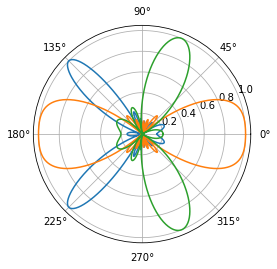

In [5]:
#Testing (beam_dir, beam_width) Beamset
from Source.antenna.ula import var_steervec
from Source.misc_fun.utils import Generate_Beams, var_plotbeam

width_vec = np.array([np.pi/8])
beamset = Generate_Beams(8,width_vec)

print("Beamset: {}".format(beamset))
print("Bemset in deg: {}".format([(x[0]*180/np.pi,x[1]) for x in beamset]))

tx_beam = var_steervec(8,beamset[5], 0)
print("Ntx: {}, active Ntx: {}, Beam: {}".format(8, 4, tx_beam))

theta, gr = var_plotbeam(beamset[5], 8)
theta2, gr2 = var_plotbeam(beamset[7], 8)
theta3, gr3 = var_plotbeam(beamset[2], 4)
ax = plt.subplot(111, projection='polar')
##print(theta.shape, gr.shape)
ax.plot(theta,gr, theta2, gr2, theta3,gr3)
plt.show()
    

In [6]:
#Choose the environment
em = EnvManager(device, 'combrf-v7', seed)
available_actions = em.num_actions_available()
random.seed(seed)
state_size = em.state_size()
print(em.env.ch_model)
print(em.env.sc_xyz)
#Select the strategy
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 3500)

if PRIORITIZED_REPLAY:
    beta_strategy = EpsilonGreedyStrategy(PER_BETA, 1.0, eps_decay, 3500)

#Initialize the agent
agent = Agent(strategy, state_size, available_actions, seed, device)

#Instantiate MemoryBuffer
if not PRIORITIZED_REPLAY:
    memory = ReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, seed, device)
else:
    memory = PrioritizedReplayBuffer(available_actions, BUFFER_SIZE, BATCH_SIZE, PER_ALPHA,seed, device)

policy_net = QNetwork(state_size, available_actions, seed).to(device)
target_net = QNetwork(state_size, available_actions, seed).to(device)
print(policy_net)

#Initialize target_net weights to policy_net weights
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #Set the target_net in eval mode

#Select the optimizer
optimizer = optim.Adam(params=policy_net.parameters(), lr=LR)

uma-los
[]
QNetwork(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=5, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=400, bias=True)
    (2): Linear(in_features=400, out_features=64, bias=True)
  )
  (softmax): Softmax(dim=1)
  (output): Linear(in_features=64, out_features=8, bias=True)
)


In [7]:
print("tx_locs: {}".format(em.env.tx_locs))

tx_locs: [array([[-52.99192642, -84.80480962,  21.5       ]])]


In [8]:
print("Beamset: {}".format(em.env.BeamSet))

Beamset: [(0.39269908, 8) (0.78539816, 8) (1.17809725, 8) (1.57079633, 8)
 (1.96349541, 8) (2.35619449, 8) (2.74889357, 8) (3.14159265, 8)]


## Test with random untrained actions

In [9]:
obs = em.env.reset(np.exp(1j * 2 * np.pi * 0.6),0)
#print(len(em.env.beamwidth_vec))
#print(em.env.action_space.n)
print(obs)
ep_rwd=[]
while True:
    action = random.randrange(em.env.action_space.n)
    
    obs, rwd, done,_ = em.env.step(action)
    print(action)
    ep_rwd.append(rwd)
    if done:
        break
        
print("Episode score: {}".format(np.sum(ep_rwd)))

[[ 0.125       0.         -0.05299193 -0.08480481  0.95555556]]
6
6
0
4
7
6
4
Episode score: 4.0


In [10]:
moving_rpts = [[np.array([rp_loc])] for rp_loc in em.env.sc_xyz]

#print("Initial: \n", moving_rpts)

for i in range(2):
    for ndx in range(len(moving_rpts)):
        if (ndx == 0) or (ndx == 1):
            last_loc = moving_rpts[ndx][-1]
            new_loc = np.array([[last_loc[0][0]+em.env.rx_stepsize, last_loc[0][1], last_loc[0][2]]]) 
            moving_rpts[ndx].append(new_loc)
        elif (ndx == 2) or (ndx == 3):
            last_loc = moving_rpts[ndx][-1]
            new_loc = np.array([[last_loc[0][0], last_loc[0][1]-em.env.rx_stepsize, last_loc[0][2]]]) 
            moving_rpts[ndx].append(new_loc)

print("After adding moving patterns: ", moving_rpts)



After adding moving patterns:  []


In [11]:
eps_scpts = []

for i in range(episodes):
    #print(random.choice(moving_rpts[0]))
    sc_pts = np.array([random.choice(moving_rpts[ndx])[0] for ndx in range(len(moving_rpts))])
    eps_scpts.append(sc_pts)

#print(eps_scpts)

In [12]:
print(eps_scpts[7])

[]


In [13]:
print(em.env.obs_space.nvec[3])

1


## Train the DQN agent

Episode 3000,	Score: 3.00, eps: 0.5, moving avg_rwd: 0.5400000214576721, , ep_len: 4, ep_loss: 4.98992109298706056059249076843263
test_eps: 3000, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(157.5, 8), (157.5, 8), (157.5, 8), (157.5, 8)]
data rates: [10.971203716631598, 10.971203716631598, 10.971203716631598, 10.971203716631598]
min exh_rate: 5.052281419914825, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 10.971203716631598, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3001,	Score: 3.00, eps: 0.5, moving avg_rwd: 0.5699999928474426, , ep_len: 4, ep_loss: 4.989920139312744
test_eps: 3001, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5

Episode 3016,	Score: 3.00, eps: 0.5, moving avg_rwd: 1.0199999809265137, , ep_len: 4, ep_loss: 4.989912986755371
test_eps: 3016, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(157.5, 8), (157.5, 8), (157.5, 8), (157.5, 8)]
data rates: [11.021091486907524, 11.021091486907524, 11.021091486907524, 11.021091486907524]
min exh_rate: 5.172625115322026, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 11.021091486907524, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3017,	Score: 3.00, eps: 0.5, moving avg_rwd: 1.0499999523162842, , ep_len: 4, ep_loss: 4.989912986755371
test_eps: 3017, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100. 

Episode 3032,	Score: 3.00, eps: 0.5, moving avg_rwd: 1.5, , ep_len: 4, ep_loss: 4.989903450012207
test_eps: 3032, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(157.5, 8), (157.5, 8), (157.5, 8), (157.5, 8)]
data rates: [11.013775755254166, 11.013775755254166, 11.013775755254166, 11.013775755254166]
min exh_rate: 5.236130918734233, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 11.013775755254166, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3033,	Score: 3.00, eps: 0.5, moving avg_rwd: 1.5299999713897705, , ep_len: 4, ep_loss: 4.989901065826416
test_eps: 3033, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX di

Episode 3049,	Score: 3.00, eps: 0.5, moving avg_rwd: 2.009999990463257, , ep_len: 4, ep_loss: 4.989884376525879
test_eps: 3049, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(157.5, 8), (157.5, 8), (157.5, 8), (157.5, 8)]
data rates: [10.950902310062549, 10.950902310062549, 10.950902310062549, 10.950902310062549]
min exh_rate: 5.253185818756255, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 10.950902310062549, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3050,	Score: 3.00, eps: 0.5, moving avg_rwd: 2.0399999618530273, , ep_len: 4, ep_loss: 4.989881992340088
test_eps: 3050, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.  

Episode 3066,	Score: 3.00, eps: 0.5, moving avg_rwd: 2.5199999809265137, , ep_len: 4, ep_loss: 4.989858150482178
test_eps: 3066, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(157.5, 8), (157.5, 8), (157.5, 8), (157.5, 8)]
data rates: [10.844540937141959, 10.844540937141959, 10.844540937141959, 10.844540937141959]
min exh_rate: 5.2332470046124095, min_action_ndx: 3, beamset val: (90.0,8)
max exh_rate: 10.844540937141959, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3067,	Score: 3.00, eps: 0.5, moving avg_rwd: 2.549999952316284, , ep_len: 4, ep_loss: 4.989853382110596
test_eps: 3067, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100. 

Episode 3082,	Score: 3.00, eps: 0.5, moving avg_rwd: 3.0, , ep_len: 4, ep_loss: 4.9898176193237305
test_eps: 3082, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(157.5, 8), (157.5, 8), (157.5, 8), (157.5, 8)]
data rates: [10.721750277596739, 10.721750277596739, 10.721750277596739, 10.721750277596739]
min exh_rate: 4.242468596763713, min_action_ndx: 5, beamset val: (135.0,8)
max exh_rate: 10.721750277596739, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3083,	Score: 3.00, eps: 0.5, moving avg_rwd: 3.0, , ep_len: 4, ep_loss: 4.989812850952148
test_eps: 3083, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500

Episode 3094,	Score: 3.00, eps: 0.5, moving avg_rwd: 3.0, , ep_len: 4, ep_loss: 4.98976993560791
test_eps: 3094, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
RX dirs:  [(157.5, 8), (157.5, 8), (157.5, 8), (157.5, 8)]
data rates: [10.630095047906048, 10.630095047906048, 10.630095047906048, 10.630095047906048]
min exh_rate: 2.703703684549802, min_action_ndx: 5, beamset val: (135.0,8)
max exh_rate: 10.630095047906048, max_action_ndx: 6, beamset val: (157.5,8)

Episode 3095,	Score: 3.00, eps: 0.5, moving avg_rwd: 3.0, , ep_len: 4, ep_loss: 4.989765167236328
test_eps: 3095, eps_rwd: 3.0
TX loc: [[-52.99192642 -84.80480962  21.5       ]]
SC_xyz: [[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
TX dirs:  [(22.50000

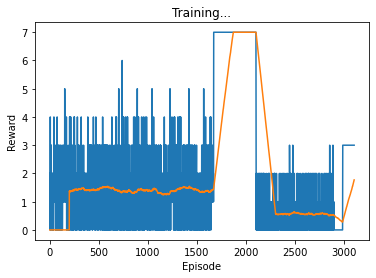

No. of false positives: 0


In [14]:
ep_rewards = []
test_rewards = []
test_data_rates = []
test_eps_iters=[]
test_minexh_rates = []
test_maxexh_rates = []
false_positives =0
policy_net.train()
test_txbdir = 0

strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 2100)
outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)
train_steps = 0
for episode in range(episodes):
 
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = []
    rx_dirs = []
    data_rates =[]
    #agent.current_step +=1
    train_steps +=1
    
    #changing from LoS to NLoS and viceversa
    if(episode == 2100):
        strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 1000)
        train_steps = 1
        em.env.sc_xyz = np.array([[-100,50,21.5], [-100,-50,21.5], [-50,100,21.5],[50,100,21.5]])#np.array([[-100,50,11.5], [-100,-50,11.5], [-50,100,11.5],[50,100,11.5]])#np.array([[50,0,0], [-50,-100,0], [100,50,0],[50,-100,0]])#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])#np.array([[0,100,0]])#np.array([[0,100,0],[250,0,0],[-200,-150,0]]) #reflection points for now
        em.env.ch_model ='uma-nlos'#'uma-nlos' #free-space path loss model
        em.env.init_ch_model = 'uma-nlos'
        em.env.goal_steps = 4
        #print("came here")
    
    #Testing the last 100 episodes
    if ((episode+1) >= (episodes-100)):
        eps = 0.5#strategy.get_exploration_rate(train_steps)
        agent.dqnaction_list = []
        agent.action_flag =-1
        tx_num = em.env.get_txloc_ndx(np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]]))
        rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + test_txbdir]
        #rbdir_ndx = rbdir_ndx_tensor.item()
        #rbdir_ndx = 0
        #print("test rbdir_ndx: {}, tx_num: {}", rbdir_ndx, tx_num)
        
        obs = em.test_reset(np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]]), em.env.sc_xyz, ch_randvals[episode], rbdir_ndx,test_txbdir)
        test_txbdir = (test_txbdir + 1) % em.env.obs_space.nvec[3]
        em.env.reward_list = []
        em.env.reward_list.append(float(np.around(1.0, decimals=2)))
        #em.env.temprwd_list = []
        #em.env.temprwd_list.append(float(np.around(1.0, decimals=2)))
        tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
        rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
        data_rates.append(em.env.rate)

        
    else:
        eps = strategy.get_exploration_rate(train_steps)
        #if(episode >2100):
        #    print(eps)
        agent.dqnaction_list = []
        #tx_num = self.get_txloc_ndx(np.array([[-100,-100,21.5]]))
        #rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * self.obs_space.nvec[3] + test_txbdir]        
        agent.action_flag =-1
        obs = em.reset(ch_randvals[episode], eps)
        if(eps <= 0.5):
            agent.action_flag = 1
        #    agent.dqnaction_list.append(em.env.rbdir_ndx)
        else:
            agent.action_flag = 0
            
        em.env.action_list = []
        em.env.action_list.append(em.env.rbdir_ndx)
        agent.randaction_list = []
        agent.actionflag_list = []
        agent.randaction_list.append(em.env.rbdir_ndx)
        agent.actionflag_list.append(agent.action_flag)
        em.env.reward_list = []
        em.env.reward_list.append(float(np.around(1.0, decimals=2)))
        tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
        rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
        data_rates.append(em.env.rate)
        
    
    if PRIORITIZED_REPLAY:
        beta = beta_strategy.get_exploration_rate(train_steps)
    
    while True:

        agent.action_flag = -1
        action = agent.act(obs, policy_net, eps, 8)
        agent.actionflag_list.append(agent.action_flag)
        #print(action)
        next_obs, reward, done, _ = em.step(action)
        em.env.action_list.append(action.item())
        em.env.reward_list.append(float(np.around(reward.item(), decimals=2)))
        #em.env.temprwd_list.append(float(np.around(temp_rwd.item(), decimals=2)))
        #em.env.epsilon_list.append(eps)
        tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
        rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
        data_rates.append(em.env.rate)

        ep_rwd += reward.item()
        
        min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = em.env.get_minmax_exhrate(ch_randvals[episode])
        
        next_qactionvals = target_net(next_obs).detach().data.cpu().numpy()[0]
        next_qactions= np.argsort(next_qactionvals)[::-1]
        
        #for a in next_qactions:
        #    if a not in agent.dqnaction_list:
        #        next_qact = a
        #        break
        next_act = torch.tensor(np.array([next_qactions[0]]), dtype=torch.long).to(device)
        #print("obs: {}, action: {}, reward: {}, next_obs:{}, next_action: {}, done: {}".format(obs, action, reward, next_obs, next_act, done))
        #print("dqnactionlist: {}, Next qactionvals: {}, next_qactions: {}, selected_nextact:{}".format(agent.dqnaction_list,next_qactionvals, next_qactions, next_act))
        #print(action)
        memory.add(obs, action, reward, next_obs, next_act, done)
        
        #current_qval = policy_net(obs).gather(1,index=action.unsqueeze(-1))
        #print(current_qval, current_qval.size())
        
        #print(next_qact, action)
        #next_qval = target_net(next_obs).detach().gather(1,index=next_qact.unsqueeze(-1))
        #print(next_qval)
        
        
        obs = next_obs
        timestep +=1
        if done:
            if memory.can_provide_sample():

                if PRIORITIZED_REPLAY:
                    experiences = memory.sample(beta)
                    observations, actions, rewards, next_observations, dones, weights, batch_indices = experiences
                else:
                    experiences = memory.sample()
                    observations, actions, rewards, next_observations, next_actions, dones = experiences
                    weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None

                #print(observations.shape, observations.dtype)
                #print(actions.unsqueeze(-1).shape)
                current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*

                #next_q_values = target_net(next_observations).detach().max(1)[0]
                next_q_values = target_net(next_observations).detach().gather(1,index=next_actions.unsqueeze(-1))#min(1)[0]
                #next_q_actionvals = target_net(next_observations).detach().data.cpu().numpy()[0]
                #next_qactions = np.argsort(next_q_actionvals)[::-1]
                #for i in range(len(next_qactions)):
                #    if next_qactions[i] not in agent.dqnaction_list:

                target_q_values = ((next_q_values*GAMMA*(~dones.unsqueeze(-1))) + rewards.unsqueeze(-1))
                #print(current_q_values.size())
                #print(target_q_values.size())
                #print(dones.unsqueeze(-1).size())
                #print(next_actions.size(), actions.size(), next_q_values.size(), rewards.unsqueeze(-1).size())
                #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
                td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
                loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.float()-current_q_values),  reduction='sum')
                #loss = F.l1_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction=None)
                #loss = F.cross_entropy(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction='mean')
                #loss = F.cross_entropy(current_q_values, target_q_values.unsqueeze(1).long(),  reduction='mean')
                #print(target_q_values.float()-current_q_values)
                #weighted_loss = torch.mean(weights*loss)
                #print("loss: ", loss)
                #loss = ALPHA*loss
                #ep_loss += weighted_loss.item()
                ep_loss = loss.item()

                optimizer.zero_grad()
                #weighted_loss.backward()
                loss.backward()
                optimizer.step()

            if PRIORITIZED_REPLAY:
                comp_errors = np.array([x[0] for x in td_errors.cpu().data.numpy()])
                new_priorities = np.abs(comp_errors) + 1e-6
                #print(new_priorities)
                memory.update_priorities(batch_indices.cpu().data.numpy(), new_priorities)

            #Update the policy network
            #if episode % UPDATE_EVERY == 0:
            #    target_net.load_state_dict(policy_net.state_dict())
            for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
                target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
        
        
            ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, ep_rewards)
            print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, , ep_len: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], em.env.rbdir_count, ep_loss), end="\r")
            #plot(episode_rewards, 100)
            if((episode+1) < (episodes-100)):
                tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
                em.env.dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.rbdir_count)
                em.env.dqnepaction_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.action_list)
                em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(eps)
                em.env.dqnactionflag_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(agent.actionflag_list)
                em.env.dqnactionrwd_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.reward_list)
                #em.env.dqntemprwd_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.temprwd_list)
                
                if((em.env.rbdir_count-1) == em.env.goal_steps):
                    em.env.dqneplen_counter[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] += 1
        
            #if(((episode+1) >= 6000) or (3000 <= (episode+1)<=3500)):
            if((episode+1) >= (episodes-100)):
                
                test_data_rates.append(max(data_rates))
                test_eps_iters.append(timestep)
                test_minexh_rates.append(min_exh_rate)
                test_maxexh_rates.append(max_exh_rate)
                
                #if (timestep > 3):
                #    if(timestep >=8):
                #        false_positives +=1
                #if (min_exh_rate == max_exh_rate):
                print("\ntest_eps: {0}, eps_rwd: {1}".format(episode+1, ep_rwd))
                print("TX loc: {}".format(em.env.tx_loc))
                print("SC_xyz: {}".format(em.env.sc_xyz))
                print("TX dirs: ", tx_dirs)
                print("RX dirs: ", rx_dirs)
                print("data rates: {}".format(data_rates))
                print("min exh_rate: {}, min_action_ndx: {}, beamset val: ({},{})".format(min_exh_rate, min_action_ndx, em.env.BeamSet[min_action_ndx][0]*180/np.pi,em.env.BeamSet[min_action_ndx][1]))
                print("max exh_rate: {}, max_action_ndx: {}, beamset val: ({},{})\n".format(max_exh_rate, max_action_ndx, em.env.BeamSet[max_action_ndx][0]*180/np.pi, em.env.BeamSet[max_action_ndx][1]))
                
            timestep = 0
            break
            
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')
plot(ep_rewards, 200, test_rewards) 
print("No. of false positives: {}".format(false_positives))

ep_rewards = []
test_rewards = []
test_data_rates = []
test_eps_iters=[]
test_minexh_rates = []
test_maxexh_rates = []
false_positives =0
policy_net.train()
test_txbdir = 0

strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 4100)
outer = tqdm.notebook.tqdm(total=episodes, desc='training loop: ', position=0)
train_steps = 0
for episode in range(episodes):
 
    ep_loss = 0.0
    ep_rwd = 0.0
    timestep = 0
    tx_dirs = []
    rx_dirs = []
    data_rates =[]
    #agent.current_step +=1
    train_steps +=1
    
    
    #changing from LoS to NLoS and viceversa
    
    if((episode+1) == (episodes-1000)):
        strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 4100)
        train_steps = 1
    if ((episode+1) >= (episodes-1000)):    
        #strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay, 4100)
        eps = strategy.get_exploration_rate(train_steps)
        #print(eps, train_steps)
        agent.dqnaction_list = []
        agent.action_flag =-1
        em.env.sc_xyz = np.array([[-100,50,21.5], [-100,-50,21.5], [-50,100,21.5],[50,100,21.5]])#np.array([[-100,50,11.5], [-100,-50,11.5], [-50,100,11.5],[50,100,11.5]])#np.array([[50,0,0], [-50,-100,0], [100,50,0],[50,-100,0]])#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])#np.array([[0,100,0]])#np.array([[0,100,0],[250,0,0],[-200,-150,0]]) #reflection points for now
        em.env.ch_model ='uma-nlos'#'uma-nlos' #free-space path loss model
        em.env.init_ch_model = 'uma-nlos'
        em.env.goal_steps = 4
        obs = em.reset(ch_randvals[episode], eps)
        
        if(eps <= 0.5):
            agent.action_flag = 1
        #    agent.dqnaction_list.append(em.env.rbdir_ndx)
        else:
            agent.action_flag = 0
            
        em.env.action_list = []
        em.env.action_list.append(em.env.rbdir_ndx)
        agent.randaction_list = []
        agent.actionflag_list = []
        agent.randaction_list.append(em.env.rbdir_ndx)
        agent.actionflag_list.append(agent.action_flag)
        em.env.reward_list = []
        em.env.reward_list.append(float(np.around(1.0, decimals=2)))
        #em.env.temprwd_list = []
        #em.env.temprwd_list.append(float(np.around(1.0, decimals=2)))    
    
    elif ((episode+1) >= (episodes-100)):
        eps = strategy.get_exploration_rate(train_steps)
        agent.dqnaction_list = []
        agent.action_flag =-1
        tx_num = em.env.get_txloc_ndx(np.array([[-100*np.cos(53*np.pi/180),-100*np.sin(53*np.pi/180),21.5]]))
        rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * em.env.obs_space.nvec[3] + test_txbdir]
        rbdir_ndx = rbdir_ndx_tensor.item()
        #rbdir_ndx = 0
        
        obs = em.test_reset(np.array([[-100*np.cos(53*np.pi/180),-100*np.sin(53*np.pi/180),21.5]]), em.env.sc_xyz, ch_randvals[episode], rbdir_ndx,test_txbdir)
        test_txbdir = (test_txbdir + 1) % em.env.obs_space.nvec[3]
        em.env.reward_list = []
        em.env.reward_list.append(float(np.around(1.0, decimals=2)))
        #em.env.temprwd_list = []
        #em.env.temprwd_list.append(float(np.around(1.0, decimals=2)))
        
    else:
        eps = strategy.get_exploration_rate(train_steps)
        agent.dqnaction_list = []
        #tx_num = self.get_txloc_ndx(np.array([[-100,-100,21.5]]))
        #rbdir_ndx = em.env.dqnbestbeam_ndxlist[tx_num * self.obs_space.nvec[3] + test_txbdir]        
        agent.action_flag =-1
        obs = em.reset(ch_randvals[episode], eps)
        if(eps <= 0.5):
            agent.action_flag = 1
        #    agent.dqnaction_list.append(em.env.rbdir_ndx)
        else:
            agent.action_flag = 0
            
        em.env.action_list = []
        em.env.action_list.append(em.env.rbdir_ndx)
        agent.randaction_list = []
        agent.actionflag_list = []
        agent.randaction_list.append(em.env.rbdir_ndx)
        agent.actionflag_list.append(agent.action_flag)
        em.env.reward_list = []
        em.env.reward_list.append(float(np.around(1.0, decimals=2)))
        #em.env.temprwd_list = []
        #em.env.temprwd_list.append(float(np.around(1.0, decimals=2)))
        
    
    if PRIORITIZED_REPLAY:
        beta = beta_strategy.get_exploration_rate(train_steps)
    
    while True:
        tx_dirs.append((em.env.tx_bdir[0]*(180/np.pi), em.env.tx_bdir[1]))
        rx_dirs.append((em.env.rx_bdir[0]*(180/np.pi), em.env.rx_bdir[1]))
        data_rates.append(em.env.rate)

        agent.action_flag = -1
        action = agent.act(obs, policy_net, eps, 8)
        agent.actionflag_list.append(agent.action_flag)
        #print(action)
        next_obs, reward, done, _ = em.step(action)
        em.env.action_list.append(action.item())
        em.env.reward_list.append(float(np.around(reward.item(), decimals=2)))
        #em.env.temprwd_list.append(float(np.around(temp_rwd.item(), decimals=2)))
        #em.env.epsilon_list.append(eps)
        
        #agent.step(obs, action, reward, next_obs, done)
        ep_rwd += reward.item()
        
        min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = em.env.get_minmax_exhrate(ch_randvals[episode])
        
        next_qactionvals = target_net(next_obs).detach().data.cpu().numpy()[0]
        next_qactions= np.argsort(next_qactionvals)[::-1]
        
        #for a in next_qactions:
        #    if a not in agent.dqnaction_list:
        #        next_qact = a
        #        break
        next_act = torch.tensor(np.array([next_qactions[0]]), dtype=torch.long).to(device)
        #print("obs: {}, action: {}, reward: {}, next_obs:{}, next_action: {}, done: {}".format(obs, action, reward, next_obs, next_act, done))
        #print("dqnactionlist: {}, Next qactionvals: {}, next_qactions: {}, selected_nextact:{}".format(agent.dqnaction_list,next_qactionvals, next_qactions, next_act))
        #print(action)
        memory.add(obs, action, reward, next_obs, next_act, done)
        
        #current_qval = policy_net(obs).gather(1,index=action.unsqueeze(-1))
        #print(current_qval, current_qval.size())
        
        #print(next_qact, action)
        #next_qval = target_net(next_obs).detach().gather(1,index=next_qact.unsqueeze(-1))
        #print(next_qval)
        
        
        obs = next_obs
        
        if memory.can_provide_sample():

            if PRIORITIZED_REPLAY:
                experiences = memory.sample(beta)
                observations, actions, rewards, next_observations, dones, weights, batch_indices = experiences
            else:
                experiences = memory.sample()
                observations, actions, rewards, next_observations, next_actions, dones = experiences
                weights, batch_indices = torch.tensor(np.ones_like(rewards.cpu().data.numpy())).to(device), None

            #print(observations.shape, observations.dtype)
            #print(actions.unsqueeze(-1).shape)
            current_q_values = policy_net(observations).gather(1,index=actions.unsqueeze(-1))#(1-ALPHA)*

            #next_q_values = target_net(next_observations).detach().max(1)[0]
            next_q_values = target_net(next_observations).detach().gather(1,index=next_actions.unsqueeze(-1))#min(1)[0]
            #next_q_actionvals = target_net(next_observations).detach().data.cpu().numpy()[0]
            #next_qactions = np.argsort(next_q_actionvals)[::-1]
            #for i in range(len(next_qactions)):
            #    if next_qactions[i] not in agent.dqnaction_list:

            target_q_values = ((next_q_values*GAMMA*(~dones.unsqueeze(-1))) + rewards.unsqueeze(-1))
            #print(current_q_values.size())
            #print(target_q_values.size())
            #print(dones.unsqueeze(-1).size())
            #print(next_actions.size(), actions.size(), next_q_values.size(), rewards.unsqueeze(-1).size())
            #loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1).float())
            td_errors = ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values)
            loss = F.mse_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.float()-current_q_values),  reduction='sum')
            #loss = F.l1_loss(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction=None)
            #loss = F.cross_entropy(torch.zeros(current_q_values.size()).to(device), ALPHA*(target_q_values.unsqueeze(1).float()-current_q_values),  reduction='mean')
            #loss = F.cross_entropy(current_q_values, target_q_values.unsqueeze(1).long(),  reduction='mean')
            #print(target_q_values.float()-current_q_values)
            #weighted_loss = torch.mean(weights*loss)
            #print("loss: ", loss)
            #loss = ALPHA*loss
            #ep_loss += weighted_loss.item()
            ep_loss = loss.item()

            optimizer.zero_grad()
            #weighted_loss.backward()
            loss.backward()
            optimizer.step()

            if PRIORITIZED_REPLAY:
                comp_errors = np.array([x[0] for x in td_errors.cpu().data.numpy()])
                new_priorities = np.abs(comp_errors) + 1e-6
                #print(new_priorities)
                memory.update_priorities(batch_indices.cpu().data.numpy(), new_priorities)

            #Update the policy network
            #if episode % UPDATE_EVERY == 0:
            #    target_net.load_state_dict(policy_net.state_dict())
            for local_param, target_param in zip(policy_net.parameters(), target_net.parameters()):
                target_param.data.copy_(TAU*local_param.data + (1.0-TAU)*target_param.data)
        
        timestep +=1
        if done:
        
            ep_rewards.append(ep_rwd)
            moving_avg_rwd = get_moving_average(100, ep_rewards)
            print('\rEpisode {},\tScore: {:.2f}, eps: {}, moving avg_rwd: {}, , ep_len: {}, ep_loss: {}'.format(episode+1, ep_rwd, eps, moving_avg_rwd[-1], em.env.rbdir_count, ep_loss), end="\r")
            #plot(episode_rewards, 100)
            if((episode+1) < (episodes-100)):
                tx_num = em.env.get_txloc_ndx(em.env.tx_loc)
                em.env.dqneplen_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.rbdir_count)
                em.env.dqnepaction_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.action_list)
                em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(eps)
                em.env.dqnactionflag_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(agent.actionflag_list)
                em.env.dqnactionrwd_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.reward_list)
                #em.env.dqntemprwd_list[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx].append(em.env.temprwd_list)
                
                if((em.env.rbdir_count-1) == em.env.goal_steps):
                    em.env.dqneplen_counter[tx_num * em.env.obs_space.nvec[3] + em.env.txdir_ndx] += 1
        
            #if(((episode+1) >= 6000) or (3000 <= (episode+1)<=3500)):
            if((episode+1) >= (episodes-100)):
                
                test_data_rates.append(max(data_rates))
                test_eps_iters.append(timestep)
                test_minexh_rates.append(min_exh_rate)
                test_maxexh_rates.append(max_exh_rate)
                
                #if (timestep > 3):
                #    if(timestep >=8):
                #        false_positives +=1
                #if (min_exh_rate == max_exh_rate):
                print("\ntest_eps: {0}, eps_rwd: {1}".format(episode+1, ep_rwd))
                print("TX loc: {}".format(em.env.tx_loc))
                print("SC_xyz: {}".format(em.env.sc_xyz))
                print("TX dirs: ", tx_dirs)
                print("RX dirs: ", rx_dirs)
                print("data rates: {}".format(data_rates))
                print("min exh_rate: {}, min_action_ndx: {}, beamset val: ({},{})".format(min_exh_rate, min_action_ndx, em.env.BeamSet[min_action_ndx][0]*180/np.pi,em.env.BeamSet[min_action_ndx][1]))
                print("max exh_rate: {}, max_action_ndx: {}, beamset val: ({},{})\n".format(max_exh_rate, max_action_ndx, em.env.BeamSet[max_action_ndx][0]*180/np.pi, em.env.BeamSet[max_action_ndx][1]))
                
            timestep = 0
            break
            
        
    
    '''    
    if ((episode == 0) or (episode+1) == 3100) or (((episode+1) > 3100) and ((train_steps) % (TEST_EVERY) == 0)):
        #test some episodes to check the performance
        policy_net.eval()
        test_ep_rwds = []
        for test_eps in range(test_episodes):
            obs = em.test_reset(test_loc, em.env.action_space.sample(), em.env.sc_xyz, ch_randvals[episode+test_eps+1])
            test_score=0
            tx_dirs = []
            rx_dirs = []
            data_rates =[]
            step = 0
            done = False
            while not done:
                action = policy_net(obs).argmax(dim=1).to(device)#agent.act(state_tensor, policy_net)
                #print("timestep: ",step, policy_net(obs),policy_net(obs).size(), action)
                tx_dirs.append(em.env.tx_bdir*(180/np.pi))
                rx_dirs.append(em.env.rx_bdir*(180/np.pi))
                data_rates.append(em.env.rate)
                next_obs, reward, done, _ = em.step(action)
                step+=1
                print("\ntstep: {0}, obs: {1}, action: {2}, next_obs: {3}, rwd: {4}, done: {5}".format(step, obs.cpu().data.numpy(), action.cpu().data.numpy(), next_obs.cpu().data.numpy(), reward.item(), done.item()))
                test_score+=reward.item()
                obs = next_obs
            
            print("test_eps: {0}, eps_rwd: {1}".format(test_eps+1, test_score))
            print("TX loc: {}".format(em.env.tx_loc))
            print("TX dirs: ", tx_dirs)
            print("RX dirs: ", rx_dirs)
            print("data rates: {}".format(data_rates))
            min_exh_rate, max_exh_rate,min_action_ndx,max_action_ndx,_,_ = em.env.get_minmax_exhrate(ch_randvals[episode+test_eps+1])
            print("min exh_rate: {}, min_action_ndx: {}".format(min_exh_rate, min_action_ndx))
            print("max exh_rate: {}, max_action_ndx: {}".format(max_exh_rate, max_action_ndx))
            
            test_ep_rwds.append(test_score)
            test_rewards.append(test_score)
            test_data_rates.append(data_rates[-1])
            test_minexh_rates.append(min_exh_rate)
            test_maxexh_rates.append(max_exh_rate)
            
        print("Average test_ep_score: {}\n".format(np.mean(test_ep_rwds)))
        policy_net.train()
        #agent.current_step=0
        train_steps = 0
        strategy =EpsilonGreedyStrategy(0.5, eps_end, 0.997)#0.1
    else:
        test_rewards.append(0)
        test_data_rates.append(0)
        test_minexh_rates.append(0)
        test_maxexh_rates.append(0)
    '''
    # update tqdm bar
    outer.update(1)
    
torch.save(policy_net.state_dict(), 'checkpoint.pth')

#timer.finish()
plot(ep_rewards, 200, test_rewards)
print("No. of false positives: {}".format(false_positives))

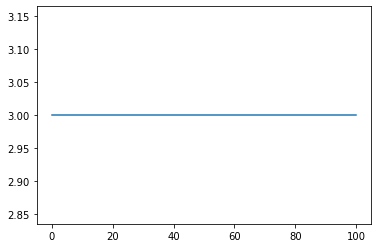

3.0 101


In [15]:
fig=plt.figure()
min_ndx=0
max_ndx=500
plt.plot(test_eps_iters[min_ndx:max_ndx])
plt.show()
print(np.mean(test_eps_iters), len(test_eps_iters))

In [16]:
print(em.env.ch_model)
print(em.env.sc_xyz)

test_net = QNetwork(state_size, available_actions, seed).to(device)
test_net.load_state_dict(torch.load('checkpoint.pth'))
test_net.eval()
tx_loc = np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]])
tbdir_ndx = 0
rbdir_ndx = 0
norm_tx_xloc = np.array([(tx_loc[0][0]) / 1000])  # np.max(self.rx_xcov)])#np.array([(self.tx_loc[0][0]+np.max(self.rx_xcov))/(np.max(self.rx_xcov))])#-np.min(self.rx_xcov))])
norm_tx_yloc = np.array([(tx_loc[0][1]) / 1000])  # max(np.max(self.rx_ycov),1)])#np.array([(self.tx_loc[0][1] + np.max(self.rx_ycov)) / (np.max(self.rx_ycov))])# - np.min(self.rx_ycov))])
norm_tx_zloc = np.array([(tx_loc[0][2]) / 22.5])
norm_tx_ndx = np.array([tbdir_ndx / em.env.obs_space.nvec[3]])
norm_rx_ndx = np.array([rbdir_ndx / em.env.action_space.n])
obs = np.array([np.concatenate((norm_rx_ndx, norm_tx_ndx, norm_tx_xloc, norm_tx_yloc,norm_tx_zloc), axis=0)])

obs_tensor = torch.tensor(obs, device=device, dtype=torch.float32)
#print(np.sort(test_net(obs_tensor).data.cpu().numpy()[0]))

uma-nlos
[[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]


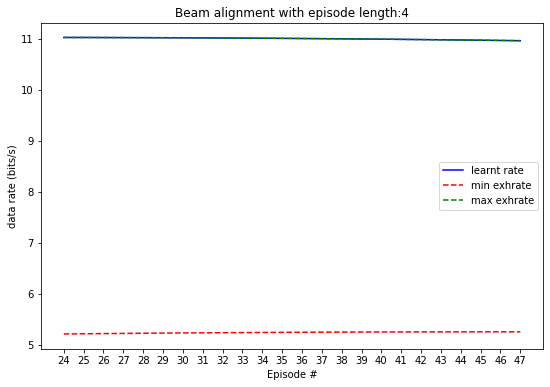

In [17]:
fig = plt.figure(figsize=[9, 6])
min_ndx=24
max_ndx=48
plt.plot(np.arange(len(test_data_rates[min_ndx:max_ndx])), test_data_rates[min_ndx:max_ndx], 'b', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_minexh_rates[min_ndx:max_ndx], 'r--', np.arange(len(test_data_rates[min_ndx:max_ndx])), test_maxexh_rates[min_ndx:max_ndx], 'g--')
#plt.plot(np.arange(len(test_data_rates[3080:3140])), test_data_rates[3080:3140], 'b', np.arange(len(test_data_rates[3080:3140])), test_minexh_rates[3080:3140], 'r--', np.arange(len(test_data_rates[3080:3140])), test_maxexh_rates[3080:3140],'g--')
#plt.plot(np.arange(len(test_data_rates[4650:4740])), test_data_rates[4650:4740], 'b', np.arange(len(test_data_rates[4650:4740])), test_minexh_rates[4650:4740], 'r--', np.arange(len(test_data_rates[4650:4740])), test_maxexh_rates[4650:4740],'g--')
#plt.plot(np.arange(len(test_data_rates[6230:])), test_data_rates[6230:], 'b', np.arange(len(test_data_rates[6230:])), test_minexh_rates[6230:], 'r--', np.arange(len(test_data_rates[6230:])), test_maxexh_rates[6230:],'g--')

plt.xticks(np.arange(0, max_ndx-min_ndx), [str(x) for x in np.arange(min_ndx, max_ndx)])
plt.legend(['learnt rate','min exhrate', 'max exhrate'])
plt.xlabel('Episode #')
plt.ylabel('data rate (bits/s)')
plt.title('Beam alignment with episode length:{}'.format(em.env.goal_steps))
plt.show()

In [18]:
min_ndx=60
max_ndx=80
print(test_data_rates[min_ndx:max_ndx])
print(test_maxexh_rates[min_ndx:max_ndx])
print(em.env.sc_xyz)
print(em.env.ch_model)
print(em.env.init_ch_model)

[10.886174082419304, 10.87937790862413, 10.87265047257721, 10.865753250380108, 10.858684623687514, 10.85194468217324, 10.844540937141959, 10.8372233681857, 10.829758041708939, 10.822540706575111, 10.81525825440048, 10.807529443538385, 10.799816266966408, 10.792149251715093, 10.784535654596354, 10.776953380439075, 10.769000797799052, 10.761090386150657, 10.75325319109571, 10.745443626826113]
[10.886174082419304, 10.87937790862413, 10.87265047257721, 10.865753250380108, 10.858684623687514, 10.85194468217324, 10.844540937141959, 10.8372233681857, 10.829758041708939, 10.822540706575111, 10.81525825440048, 10.807529443538385, 10.799816266966408, 10.792149251715093, 10.784535654596354, 10.776953380439075, 10.769000797799052, 10.761090386150657, 10.75325319109571, 10.745443626826113]
[[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
uma-nlos
uma-nlos


In [19]:
print(test_data_rates[69])
print([(x[0]*180/np.pi, x[1]) for x in em.env.BeamSet])
#print(em.env.BeamSet[9])

10.822540706575111
[(22.500000000000004, 8), (45.0, 8), (67.5, 8), (90.0, 8), (112.5, 8), (135.0, 8), (157.5, 8), (180.0, 8)]


In [20]:
print(em.env.dqnobs_counter)
print(len(em.env.dqnobs_counter))
print(np.mean(em.env.dqnobs_counter))

[3001]
1
3001.0


In [21]:
print(em.env.dqneplen_counter)
print(np.mean(em.env.dqneplen_counter))

[0]
0.0


In [22]:
tx_loc = np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]])
txdir_ndx = 0

tx_num = em.env.get_txloc_ndx(tx_loc)
obs_epiters = em.env.dqneplen_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx]

count = 0
for x,y,z,w in zip(em.env.dqnepaction_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx],em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx],em.env.dqnactionflag_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx], em.env.dqnactionrwd_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx]):
    #print("episode actions: {}, eps: {}".format(x,y,z))
    temp_list =[(i,j,k) for i,j,k in zip(x,z,w)]
    count = count + 1
    if (count >2980):
        print("NLoS episode actions: {}, eps: {}".format(temp_list,y))
    elif (count >=2300 and count <2340):
        print("NLoS-random episode actions: {}, eps: {}".format(temp_list,y))
    
    elif(count > 1990 and count <= 2000):
    #    break
        print("LoS episode actions: {}, eps: {}".format(temp_list,y))
    #else:
    #    pass
    
        
#print(em.env.dqnepsilon_list[tx_num * em.env.obs_space.nvec[3] + txdir_ndx])
#fig = plt.figure(figsize=[9, 6])
#plt.plot(np.arange(len(obs_epiters)), obs_epiters, 'b')
#plt.xlabel('Episode #')
#plt.ylabel('Episode Iterations')
#plt.title('Training convergence for tx_loc:{}, txdir: {}, ep_len:{}'.format(tx_loc, (em.env.BeamSet[txdir_ndx][0]*180/np.pi,em.env.BeamSet[txdir_ndx][1]),em.env.goal_steps))
#plt.show()

LoS episode actions: [(4, 0, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0)], eps: 0.525952380952381
LoS episode actions: [(4, 0, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0)], eps: 0.5257142857142857
LoS episode actions: [(4, 0, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0)], eps: 0.5254761904761904
LoS episode actions: [(4, 0, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0)], eps: 0.5252380952380953
LoS episode actions: [(4, 0, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0)], eps: 0.525
LoS episode actions: [(4, 0, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0)], eps: 0.5247619047619048
LoS episode actions: [(4, 0, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1.0), (4, 1, 1

In [23]:
tx_loc = np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]])
txdir_ndx = 0
#print(em.env.BeamSet[5][0]*180/np.pi)

em.env.sc_xyz = np.array([[-100,50,21.5], [-100,-50,21.5], [-50,100,21.5],[50,100,21.5]])#np.array([[-100,50,11.5], [-100,-50,11.5], [-50,100,11.5],[50,100,11.5]])#np.array([[50,0,0], [-50,-100,0], [100,50,0],[50,-100,0]])#np.array([[0,100,0], [10,50,0], [40,60,0], [70,80,0], [100,50,0], [80,85,0], [20,30,0], [10,40,0], [80,20,0]])#np.array([[0,100,0]])#np.array([[0,100,0],[250,0,0],[-200,-150,0]]) #reflection points for now
em.env.ch_model ='uma-nlos'#'uma-nlos' #free-space path loss model
em.env.init_ch_model = 'uma-nlos'
tx_num = em.env.get_txloc_ndx(tx_loc)
print(em.env.ch_model)
print(em.env.sc_xyz)
for rbdir_ndx in range(8):
    obs = em.test_reset(tx_loc, em.env.sc_xyz, np.exp(1j*2*np.pi*0.6), rbdir_ndx,txdir_ndx)
    #_ = em.env.test_reset(tx_loc, txdir_ndx, rbdir_ndx,em.env.sc_xyz, np.exp(1j * 2 * np.pi * 0.6))
    print("rbdir_ndx: {}, SNR:{}, rate: {}".format(rbdir_ndx, em.env.SNR, em.env.rate))

uma-nlos
[[-100.    50.    21.5]
 [-100.   -50.    21.5]
 [ -50.   100.    21.5]
 [  50.   100.    21.5]]
rbdir_ndx: 0, SNR:171.54159288037383, rate: 7.430800369689679
rbdir_ndx: 1, SNR:67.82593221573306, rate: 6.104880340484182
rbdir_ndx: 2, SNR:35.53753523205395, rate: 5.1913074100670995
rbdir_ndx: 3, SNR:26.33019631716017, rate: 4.772423917894336
rbdir_ndx: 4, SNR:44.5095937624667, rate: 5.50809880315588
rbdir_ndx: 5, SNR:293.1573399926007, rate: 8.20044422547795
rbdir_ndx: 6, SNR:1337.4499427946992, rate: 10.386347468741807
rbdir_ndx: 7, SNR:783.514755041545, rate: 9.61565677122569


In [24]:
tx_loc = np.array([[-100*np.cos(58*np.pi/180),-100*np.sin(58*np.pi/180),21.5]])
txdir_ndx = 0

#tx_num = em.env.get_txloc_ndx(tx_loc)
em.env.sc_xyz=np.array([])
em.env.ch_model ='uma-los'#'uma-nlos' #free-space path loss model
em.env.init_ch_model = 'uma-los'
print(em.env.ch_model)
print(em.env.sc_xyz)
for rbdir_ndx in range(8):
    obs = em.test_reset(tx_loc, em.env.sc_xyz, np.exp(1j*2*np.pi*0.6), rbdir_ndx,txdir_ndx)
    #_ = em.env.test_reset(tx_loc, txdir_ndx, rbdir_ndx,em.env.sc_xyz, np.exp(1j * 2 * np.pi * 0.6))
    print("rbdir_ndx: {}, SNR:{}, rate: {}".format(rbdir_ndx, em.env.SNR, em.env.rate))

uma-los
[]
rbdir_ndx: 0, SNR:19482.282145013483, rate: 14.24994911320547
rbdir_ndx: 1, SNR:1167.9455811827825, rate: 10.190992053209873
rbdir_ndx: 2, SNR:29729.97826787659, rate: 14.859679314002358
rbdir_ndx: 3, SNR:8853.513055176243, rate: 13.112197254293251
rbdir_ndx: 4, SNR:648560.1830488973, rate: 19.306883154260934
rbdir_ndx: 5, SNR:301888.6898456825, rate: 18.203661961124396
rbdir_ndx: 6, SNR:102464.23682350363, rate: 16.64477500690927
rbdir_ndx: 7, SNR:10666.689190960788, rate: 13.380960076443342


In [25]:
print("angle 5: ", em.env.BeamSet[5][0]*180/np.pi)
print("angle 6: ", em.env.BeamSet[6][0]*180/np.pi)
tx_loc = np.array([[-100*np.cos(45*np.pi/180),-100*np.sin(45*np.pi/180),21.5]])
print(tx_loc)

angle 5:  135.0
angle 6:  157.5
[[-70.71067812 -70.71067812  21.5       ]]


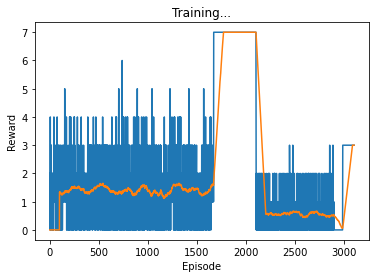

[2.0, 2.0, 1.0, 2.0, 0.0, 4.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0, 1.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 4.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 3.0, 3.0, 2.0, 1.0, 2.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 2.0, 3.0, 0.0, 1.0, 2.0, 1.0, 3.0, 0.0, 4.0, 0.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 0.0, 1.0, 3.0, 1.0, 1.0, 1.0, 0.0, 3.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 1.0, 0.0, 1.0]
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   1.33]


In [26]:
#import pickle

#memory.save('memory_checkpoint.pth')
plot(ep_rewards, 100, test_rewards)
print(ep_rewards[:100])
moving_avg_rwd = get_moving_average(100, ep_rewards[:100])
print(moving_avg_rwd)

## Test the DQN agent

[(22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8), (22.500000000000004, 8)]
[(157.5, 8), (157.5, 8), (157.5, 8), (157.5, 8)]


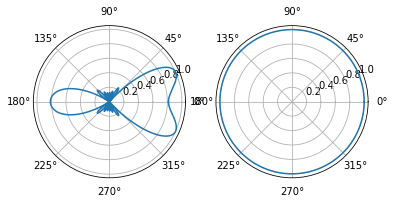

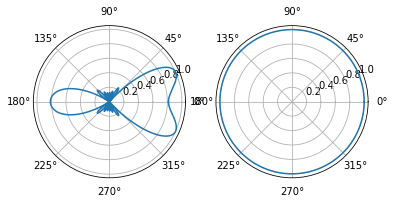

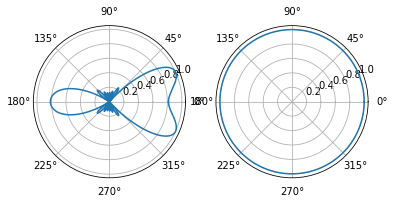

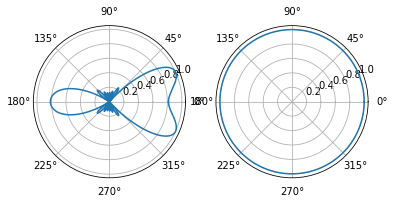

In [27]:
from Source.misc_fun.utils import var_plotbeam

print(tx_dirs)
print(rx_dirs)
for tx_ang, rx_ang in zip(tx_dirs, rx_dirs):
    tx_theta, tx_gr = var_plotbeam(tx_ang, em.env.N_tx)
    rx_theta, rx_gr = var_plotbeam(rx_ang, em.env.N_rx)
    ax1 = plt.subplot(122, projection='polar')
    ax1.plot(tx_theta, tx_gr)

    ax2 = plt.subplot(121, projection='polar')
    ax2.plot(rx_theta, rx_gr)

    plt.show()




## Display all exhaustive rate measurements from env

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.collections import PolyCollection
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

fig = plt.figure()
ax = fig.gca(projection='3d')
poly = PolyCollection(verts[:4], facecolors=['r', 'g', 'b', 'y'], alpha=0.6)
print(len(verts))
print(verts[0:2])
#print(np.array(tx_locs[:4]))
ax.add_collection3d(poly, zs=np.arange(1,5), zdir='y')

ax.set_xlabel('X (beam pairs)')
ax.set_ylabel('Y (tx_locs)')
ax.set_zlabel('Z (data rates)')
ax.set_xlim(0, 10)
ax.set_ylim(1, 5)
ax.set_zlim(10, 30)

plt.show()

In [28]:
print(em.env.ch_model)
print(em.env.sc_xyz)
em.env.BeamSet[5][0]*180/np.pi
np.arctan(1100/200)*180/np.pi

uma-los
[]


79.69515353123397

In [29]:
12/24, 14/24

(0.5, 0.5833333333333334)

from Source.misc_fun.utils import plotbeam

tx_theta, tx_gr = plotbeam(exh_txbeams[0]*(np.pi/180), em.env.N_tx)
rx_theta, rx_gr = plotbeam(exh_rxbeams[0]*(np.pi/180), em.env.N_rx)
ax1 = plt.subplot(122, projection='polar')
ax1.plot(tx_theta, tx_gr)

ax2 = plt.subplot(121, projection='polar')
ax2.plot(rx_theta, rx_gr)

plt.show()

